# Developing an AI application to recognise flower species

## Introduction

In this project, I will develop a deep learning image classifier to recognize different species of flowers - and deploy it in a command line application. This could be used for example, in something like a phone app that tells you the name of the flower your camera is looking at. 

The project has two parts:

1. Develop image classifier (in this jupyter notebook)
2. Deploy image classifier (in python command line applications, included in this git repo)

In part 1 where we will develop our classifier, we will use the following steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

In part 2, I will then convert the work done in part 1 into two python command line applications:

* **train.py** - Will build, train, test & save a classifier that can predict flower species
* **predict.py** - Given an image of a flower and a trained classifier, will predict the species of flower

We will use this dataset http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html which consists of 20,000+ colour images of flowers with 102 labelled categories.

While this project focusses on developing a trained classifier to predict flower species from images, it is done in such a way that it could easily be re-used to predict other things from images - given a sufficiently large & rich categorised dataset of images to train on. For example, if we had a labelled & categorised (e.g. by car model) dataset of car images - we could use these same applications to create a classifier that could predict the model of a car based on an image.

## Import libs required ##

In [2]:
# Import required modules
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from workspace_utils import active_session
import matplotlib.pyplot as plt
from PIL import Image
import json

## Initial exploration of image data

The dataset of flower images has been separated into 3 groups for training, validation & testing. Lets have a look at an example of a raw image from each of these groups.

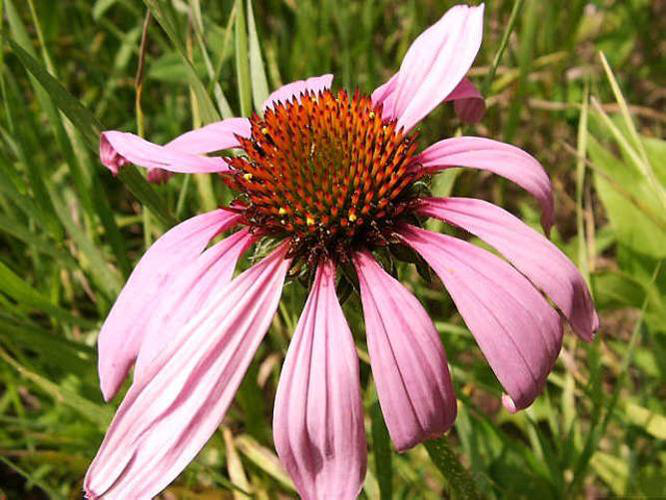

In [12]:
# Image from training sub-set
img = Image.open("flowers/train/17/image_03844.jpg")
img

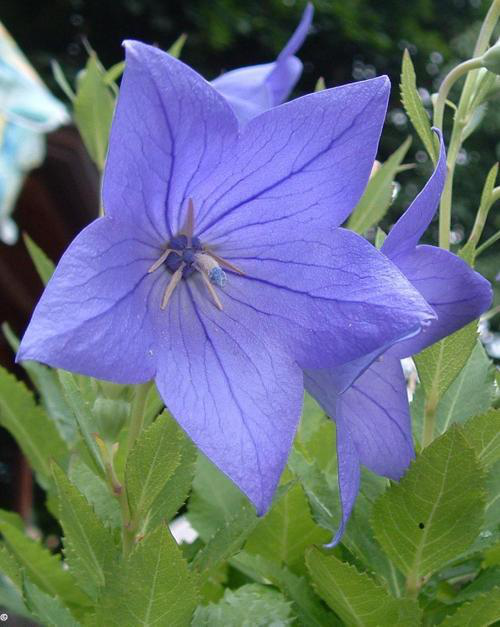

In [13]:
# Image from validation sub-set
img = Image.open("flowers/valid/19/image_06195.jpg")
img

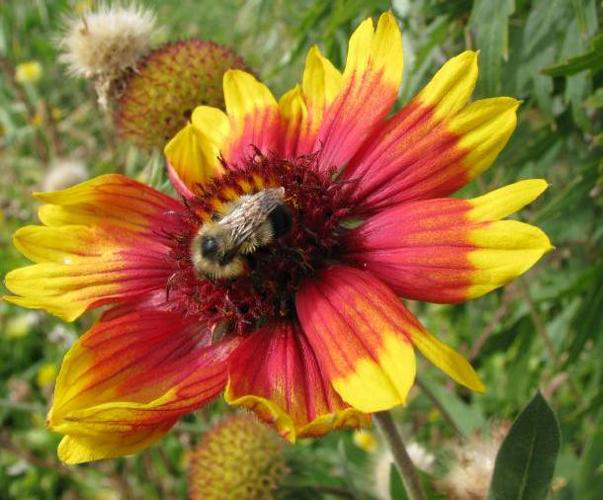

In [6]:
# Image from testing sub-set
img = Image.open("flowers/test/100/image_07896.jpg")
img

## Load the data

Here we will use the `torchvision` library to load the data. As already mentioned, the dataset is split into three parts, training, validation, and testing. For the training, I will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We will also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks (using the `pytorch` library for deep learning).

The validation and testing sets will be used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we will need to resize then crop the images to the appropriate size.

The pre-trained networks I will use from pytorch were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we will need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
# Define directory names
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Label mapping

We will also need to load in a mapping from category label to category name. For this we will use the file `cat_to_name.json` (included in this repo). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
# Define category mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, we will build and train the classifier. We will use one of the pretrained models from `torchvision.models` to get the image features. We will then build and train a new feed-forward classifier using those features.

So here we will:

* Load a [pre-trained network from pytorch](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We will aim to get a validation accuracy of at least 70% from our model, by tuning different hyperparameters (i.e. learning rate, hidden units in the classifier, epochs, etc).

Training these kinds of networks can be quite computationally expensive, and so it is common to use GPU servers to perform these training computations more quickly. For this project I have a GPU available and configured for this workspace, so I will adapt the code to be able to be run on either the default CPU or GPU.

In [5]:
# Build and train classifier

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to build model
def build_model():
    
    # Select & load pre-trained model
    model = models.vgg16(pretrained=True)
    
    # Freeze parameters of pre-trained model part by removing gradients
    for param in model.parameters():
        param.requires_grad = False
        
    # Classifier architecture parameters
    classifier_input_neurons = 25088
    classifier_hidden_neurons = 15000
    classifier_output_neurons = 102
    classifier_dropout = 0.2
        
    # Build new classifier for recognising flowers to work with vgg16 model
    model.classifier = nn.Sequential(OrderedDict([
                                    ('fc1', nn.Linear(classifier_input_neurons, classifier_hidden_neurons)),
                                    ('relu', nn.ReLU()),
                                    ('dropout', nn.Dropout(classifier_dropout)),
                                    ('fc2', nn.Linear(classifier_hidden_neurons, classifier_output_neurons)),
                                    ('output', nn.LogSoftmax(dim=1))]))
    
    # Define model loss function
    criterion = nn.NLLLoss()

    # Define training function: only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
    
    # Move model to current device
    model.to(device)
    
    # Return model components
    return model, criterion, optimizer
    

In [6]:
# Build model
model, criterion, optimizer = build_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 100461895.30it/s]


In [7]:
# Set global variables
epochs = 4 
training_steps = 0
training_loss = 0
print_every = 20

# Train network
# Ensure notebook session stays active through long runs
with active_session():
    
    # For each training pass of whole dataset/epoch
    for epoch in range(epochs):
        
        print(f"Epoch {epoch+1}")
        print("-------")
        
        # For each training batch/step of images & labels
        for inputs, labels in trainloader:
            
            # Increment training steps count
            training_steps += 1
            # Move data and label tensors to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Do forward pass through network
            logps = model(inputs)
            # Calculate loss for whole network
            loss = criterion(logps, labels)
            # Calculate gradients for each element to be trained by network (weights & biases)
            loss.backward()
            # Do back-propogation step: apply negative gradients to weights & biases
            optimizer.step()

            # Accumulate training loss
            training_loss += loss.item()

            # Every 20 training steps, validation check & output stats
            if training_steps % print_every == 0:
                
                valid_loss = 0
                accuracy = 0
                # Switch to evaluation mode - dropout inactive
                model.eval()
                # Disable gradients - not needed for modal validation/prediction
                with torch.no_grad():
                    
                    # For each validation batch of images & labels
                    for inputs, labels in validloader:
                        
                        # Move data and label tensors to device
                        inputs, labels = inputs.to(device), labels.to(device)
                        # Do forward pass through network
                        logps = model.forward(inputs)
                        # Calculate loss for network
                        batch_loss = criterion(logps, labels)
                        # Accumulate validation loss
                        valid_loss += batch_loss.item()
                        
                        # Calculate stats
                        # Get actual probabilties output from network for this batch
                        ps = torch.exp(logps)
                        # Get top probability/prediction for each image in batch
                        top_p, top_class = ps.topk(1, dim=1)
                        # Check each prediction against label (accuracy)
                        equals = top_class == labels.view(*top_class.shape)
                        # Calculate mean accuracy for this batch 
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Output stats for current training step
                print(f"Training step {training_steps}")
                print(f"Training loss: {training_loss/print_every:.3f} - "
                      f"Validation loss: {valid_loss/len(validloader):.3f} - "
                      f"Validation accuracy: {accuracy/len(validloader):.3f}")
                # Validation end - reset training loss & set model back to training mode
                training_loss = 0
                model.train()

Epoch 1
-------
Training step 20
Training loss: 27.871 - Validation loss: 3.226 - Validation accuracy: 0.260
Training step 40
Training loss: 3.195 - Validation loss: 2.041 - Validation accuracy: 0.493
Training step 60
Training loss: 2.623 - Validation loss: 1.853 - Validation accuracy: 0.559
Training step 80
Training loss: 2.401 - Validation loss: 1.455 - Validation accuracy: 0.621
Training step 100
Training loss: 2.302 - Validation loss: 1.526 - Validation accuracy: 0.592
Epoch 2
-------
Training step 120
Training loss: 2.279 - Validation loss: 1.298 - Validation accuracy: 0.637
Training step 140
Training loss: 2.118 - Validation loss: 1.356 - Validation accuracy: 0.673
Training step 160
Training loss: 2.004 - Validation loss: 1.314 - Validation accuracy: 0.661
Training step 180
Training loss: 1.971 - Validation loss: 1.224 - Validation accuracy: 0.691
Training step 200
Training loss: 1.994 - Validation loss: 1.401 - Validation accuracy: 0.657
Epoch 3
-------
Training step 220
Trainin

## Testing the classifier

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. We will run the test images through the network and measure the accuracy, the same way we did validation. As mentioned previously, we will hope to reach around 70% accuracy on the test set if the model has been trained well.


In [8]:
# Do validation on the test set

accuracy = 0
# Switch to evaluation mode - dropout inactive
model.eval()
# Disable gradients - not needed for modal testing/prediction
with torch.no_grad():
    
    # For each test batch of images & labels
    for inputs, labels in testloader:

        # Move data and label tensors to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Do forward pass through network
        logps = model.forward(inputs)

        # Calculate stats
        # Get actual probabilties output from network for this batch
        ps = torch.exp(logps)
        # Get top probability/prediction for each image in batch
        top_p, top_class = ps.topk(1, dim=1)
        # Check each prediction against label (accuracy)
        equals = top_class == labels.view(*top_class.shape)
        # Calculate mean accuracy for this batch 
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    else:
        # Output accuracy for entire test dataset
        print(f"Test accuracy: {accuracy/len(testloader):.3f}")

Test accuracy: 0.733


## Save the classifier

Now that our network is trained, it will be useful to save the model so we can load it later for making predictions. We will also save other things, such as the mapping of classes to indices which we can get from one of the image datasets.


In [7]:
# Save the classifier 
    
def save_checkpoint(model, epochs, training_steps, train_data):
    
    # Define checkpoint parameters
    checkpoint = {'class_to_idx': model.class_to_idx, # Mapping of flower classes to indices
                'model_state_dict': model.state_dict(),
                'epochs': epochs,
                'training_steps': training_steps}
    # Save it
    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model, epochs, training_steps, train_data)

## Loading the classifier

It's also useful for us to write a function that can load a classifier to rebuild the model. That way, we can come back to this project and keep working on it without having to retrain the network.

In [8]:
# Load a checkpoint and rebuild the classifier

def load_checkpoint():
    
    # Load checkpoint 
    if torch.cuda.is_available():
        checkpoint = torch.load('checkpoint.pth')
    else:
        checkpoint = torch.load('checkpoint.pth', map_location=lambda storage, loc: storage)
    # Create model
    model, criterion, optimizer = build_model()
    # Load classifier state values from checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model, criterion, optimizer

model, criterion, optimizer = load_checkpoint()
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105706029.19it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now we will write a function to use a trained network for inference. That is, we will pass an image into the network and predict the class of the flower in the image. We will write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

First we need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We will use the `PIL` library to load the image. We will write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

First, we will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Then we will need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1, so we will need to convert the values.

As before, the network expects the images to be normalized in a specific way. 

Finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array, so we will need to re-order the dimensions. The color channel needs to be first and retain the order of the other two dimensions.

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    
    # Load image from file & get dimensions
    im = Image.open(image)
    width, height = im.size
    
    # Scale image
    # (determine which is the shortest side to restrict scaling)
    if width > height:
        # Height is shortest to be set to max of 256
        im.thumbnail((width, 256), Image.ANTIALIAS)
    else:
        # Width is shortest to be set to max of 256
        im.thumbnail((256, height), Image.ANTIALIAS)
        
    # Crop center 224x224
    new_width, new_height = im.size
    left = (new_width - 224) / 2
    top = (new_height - 224) / 2
    right = (new_width + 224) / 2
    bottom = (new_height + 224) / 2
    im = im.crop((left, top, right, bottom))
    
    # Convert colour channel values from 0-255 to 0-1
    np_image = np.array(im) / 255
    
    # Normalise colour channels
    mean = np.array([0.485, 0.456, 0.406]) 
    std_dev = np.array([0.229, 0.224, 0.225]) 
    np_image = (np_image - mean) / std_dev
    
    # Re-order dimensions of numpy array
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image
    

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. 

In [10]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

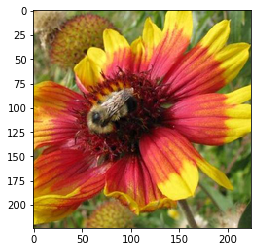

In [20]:
# Test process_image()
image = ("flowers/test/100/image_07896.jpg")
image = process_image(image)
imshow(image)

## Class Prediction

Now we have our images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We will calculate the class probabilities then find the $K$ largest values. 

Note: at this stage, the classes (flower species categories) will still be represented as integers.


In [41]:
# Predict the classes from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Process image
    np_image = process_image(image_path)
    # Convert image to tensor
    image_tensor = torch.from_numpy(np_image)
    # Add batch dimension to tensor
    image_tensor = image_tensor.unsqueeze_(0)
    # Convert to float tensor
    image_tensor = image_tensor.float()
    
    # Switch to evaluation mode - dropout inactive
    model.eval()
    # Disable gradients - not needed for model prediction
    with torch.no_grad():
    
        # Do forward pass through network
        logps = model.forward(image_tensor)
        # Get actual probabilties output from network for this image
        ps = torch.exp(logps)
        # Get topk probability/prediction for this image
        top_p, top_class = ps.topk(topk, dim=1)
        top_p = top_p.numpy()
        top_class = top_class.numpy()
        # Invert class map
        idx_to_class = {j: i for i, j in model.class_to_idx.items()}
        # Map indexes to get true class indexes
        top_classes = [idx_to_class[index] for index in top_class[0]]
        
        # Return probabilties and classes
        return top_p[0], top_classes
    
    
probs, classes = predict("flowers/test/100/image_07896.jpg", model)
print(probs)
print(classes)

[ 0.8974303   0.03979312  0.0260343   0.01662018  0.01460829]
['100', '5', '41', '54', '17']


## Sanity Checking

Now we have a trained model for predictions, we should check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

We will write a function to test the predictions of the classifier, showing the image & the actual species of the flower, and a bar chart of the top 5 predicted species and their probabilities.

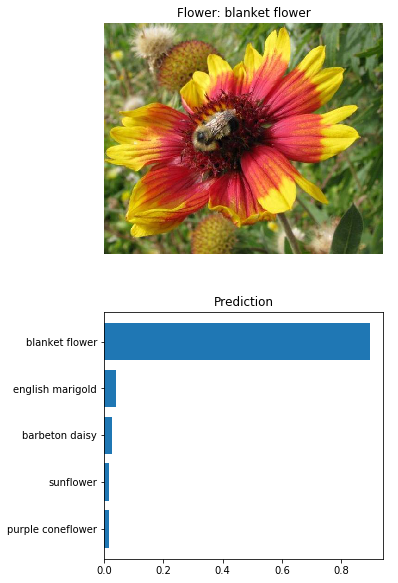

In [35]:
# Display an image along with the top 5 predicted classes

def test_prediction(image_path, model, category_map):
    
    # Get prediction of image
    probs, classes = predict(image_path, model)
    
    # Get image and file parts
    image = Image.open(image_path)
    image_filename = image_path.split('/')[-2]
    
    # Create composite plot
    fig, (subplot1, subplot2) = plt.subplots(figsize=(5,10), ncols=1, nrows=2)
    flowername = category_map[image_filename]
    
    # Plot image and true category
    subplot1.set_title('Flower: ' + flowername)
    subplot1.imshow(image)
    subplot1.axis('off')
    
    # Plot predicted categories
    yaxis_data = np.arange(len(probs))
    subplot2.set_title('Prediction')
    subplot2.barh(yaxis_data, probs)
    subplot2.set_yticks(yaxis_data)
    subplot2.set_yticklabels([category_map[x] for x in classes])
    subplot2.invert_yaxis()
    
    
    
test_prediction("flowers/test/100/image_07896.jpg", model, cat_to_name)

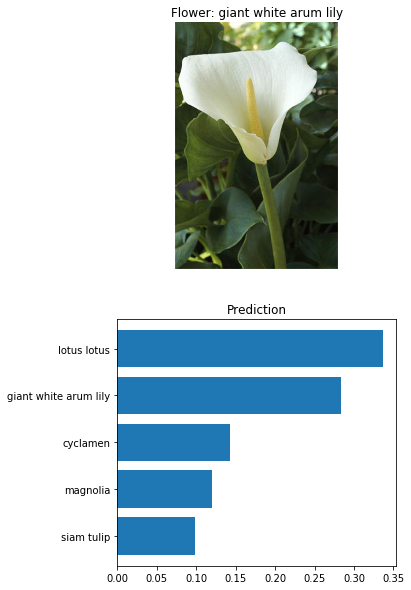

In [36]:
test_prediction("flowers/test/20/image_04910.jpg", model, cat_to_name)

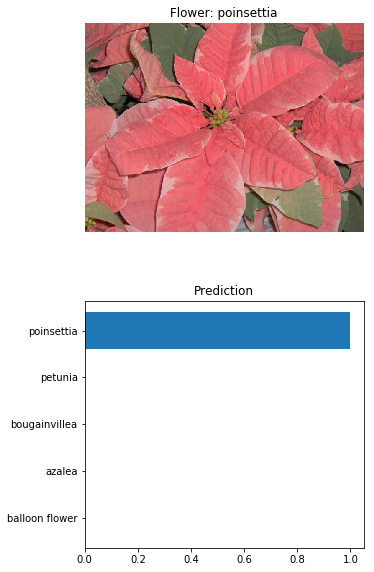

In [37]:
test_prediction("flowers/test/44/image_01502.jpg", model, cat_to_name)

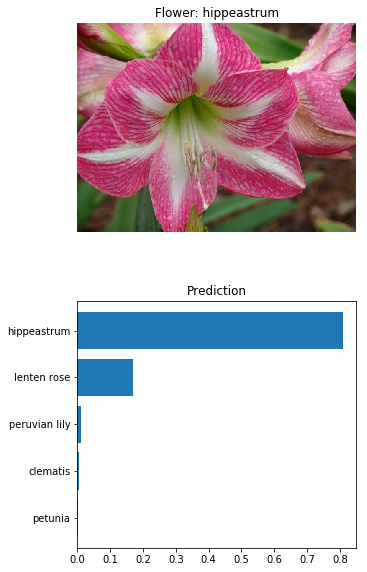

In [38]:
test_prediction("flowers/test/91/image_04851.jpg", model, cat_to_name)

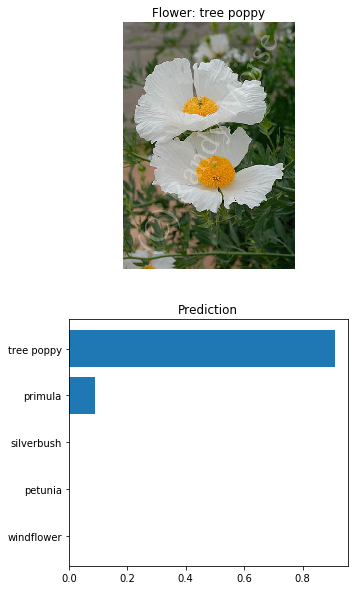

In [39]:
test_prediction("flowers/test/70/image_05308.jpg", model, cat_to_name)

We can see that the model performs quite well on these manual tests. 

It is also interesting to observe that in these tests even in the case where the top prediction is incorrect ie the second image "flowers/test/20/image_04910.jpg" (giant white arum lily), the correct species is still a very close second choice.

## Conclusion & next steps

In this first part of the project, we have developed a deep learning classifier that has a test accuracy of 73% for predicting flower species, which we have also manually verified with a few specific images.

In the next phase of the project, I have converted this work into two python command line applications:

- **train.py** - Builds, trains, tests & saves a classifier that can predict flower species
- **predict.py** - Given an image of a flower and a trained classifier, predicts the species of flower

These can both be viewed in the same git repository as this notebook.

These applications take a range of configurable parameters such as: use gpu, specify any pytorch pre-trained model, number of classifier hidden layer units, epochs, learning rate, number of predictions to return - and more.